# Capstone Project - The Battles of Neighborhoods
By Freddy Li (Jul, 2019)

## Introduction

The project is mainly to solve the question that if someone plan to open a restaurant in New York City, how he should choose the location. To solve the problem, the first step is to find the best borough according to crime and income data because a safe location surrounded by rich people might worth to invest a restaurant. Next, the neighborhoods in selected borough is explored and clustered based on the data from Foursqaure to assess the clusters of neighborhoods by the popularity of the venues, which could be the nearby neighbors to adborb the clients to step in the restaurant after visiting that venues, and categories of venues, which implies what kind of restaurants could be better choices. Finally, the list of recommended venues as neighbors from differents neighborhoods in selected borough is generated. The restaurant is recommended to open near these venues within the popular neighborhoods of worthy borough for different clusters. The investors, restaurants and food providers would feel interested in this project to help them make decission of location.

## Data

To process this project, New York Neighborhoods data, New York Crime data, New York Income data and detailed geographic data with venues information are used.

- New York Neighborhoods data: The data is from [2014 New York City Neighborhood Names](https://geo.nyu.edu/catalog/nyu_2451_34572) provided by Department of City Planning, NY to give out neighborhoods' names and locations. 
- New York crime data: The data is from [NYPD Complaint Data for Current Year](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243) provided by NYPD to display the detailed crime data by case level.
- New York income data: The data is from [NY QuickFacts](https://www.census.gov/quickfacts/fact/table/newyorkcountymanhattanboroughnewyork,bronxcountybronxboroughnewyork,queenscountyqueensboroughnewyork,kingscountybrooklynboroughnewyork,richmondcountystatenislandboroughnewyork,newyorkcitynewyork/HSG010218) provided by Census Bureau to give out the statistics until 2017 by boroughs in New York City.
- Geographic Data: The data is from [Foursquare API](https://foursquare.com/). The endpoints including venues explore, categories, next venues, like-a-venue, stats of venues and like-a-checkin are used to get the key information. 

# Methodology

To start the data exploratory analysis, we fistly prepare the environment 

In [3]:
#!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-3.1.0               |           py36_0         724 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be 

In [4]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Data Loading and Cleaning

### New York City Neighborhoods Name Data

In [5]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [6]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [7]:
neighborhoods_data = newyork_data['features']

In [8]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [9]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [10]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [11]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [12]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [13]:
neighborhoods.groupby(["Borough"])["Neighborhood"].count()

Borough
Bronx            52
Brooklyn         70
Manhattan        40
Queens           81
Staten Island    63
Name: Neighborhood, dtype: int64

### New York City Crime Data

In [14]:
url = "https://data.cityofnewyork.us/resource/7x9x-zpz6.csv"
crime = pd.read_csv(url)
crime.head()

,cmplnt_num,addr_pct_cd,boro_nm,cmplnt_fr_dt,cmplnt_fr_tm,cmplnt_to_dt,cmplnt_to_tm,crm_atpt_cptd_cd,hadevelopt,housing_psa,jurisdiction_code,juris_desc,ky_cd,law_cat_cd,loc_of_occur_desc,ofns_desc,parks_nm,patrol_boro,pd_cd,pd_desc,prem_typ_desc,rpt_dt,station_name,susp_age_group,susp_race,susp_sex,transit_district,vic_age_group,vic_race,vic_sex,x_coord_cd,y_coord_cd,latitude,longitude,lat_lon_city,lat_lon_address,lat_lon,lat_lon_state,lat_lon_zip,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih
0,857927015,10,MANHATTAN,2019-01-29T00:00:00.000,16:37:00,2019-01-29T00:00:00.000,16:45:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,106,FELONY,NaN,FELONY ASSAULT,NaN,PATROL BORO MAN SOUTH,109.0,"ASSAULT 2,1,UNCLASSIFIED",STREET,2019-01-30T00:00:00.000,NaN,18-24,BLACK,M,NaN,UNKNOWN,UNKNOWN,M,984140,211709,40.747777,-74.000398,NaN,NaN,POINT (-74.000398443 40.747777093),NaN,NaN,11722.0,12,4,10,6
1,479254687,101,QUEENS,2019-03-29T00:00:00.000,17:00:00,2019-03-29T00:00:00.000,17:10:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,107,FELONY,INSIDE,BURGLARY,NaN,PATROL BORO QUEENS SOUTH,221.0,"BURGLARY,RESIDENCE,DAY",RESIDENCE - APT. HOUSE,2019-03-29T00:00:00.000,NaN,UNKNOWN,BLACK,M,NaN,25-44,BLACK,F,1054076,157437,40.598538,-73.748560,NaN,NaN,POINT (-73.748559596 40.598537593),NaN,NaN,20529.0,51,3,47,59
2,320007604,41,BRONX,2019-02-06T00:00:00.000,02:00:00,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,105,FELONY,INSIDE,ROBBERY,NaN,PATROL BORO BRONX,396.0,"ROBBERY,BEGIN AS SHOPLIFTING",DRUG STORE,2019-02-06T00:00:00.000,NaN,45-64,BLACK,M,NaN,UNKNOWN,UNKNOWN,D,1011589,237996,40.819886,-73.901227,NaN,NaN,POINT (-73.901226998 40.819885621),NaN,NaN,10937.0,8,5,43,24
3,746022144,68,BROOKLYN,2019-01-08T00:00:00.000,22:49:00,2019-01-08T00:00:00.000,22:52:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,117,FELONY,NaN,DANGEROUS DRUGS,NaN,PATROL BORO BKLYN SOUTH,503.0,"CONTROLLED SUBSTANCE,INTENT TO",STREET,2019-01-08T00:00:00.000,NaN,25-44,WHITE,M,NaN,UNKNOWN,UNKNOWN,E,984439,166855,40.624663,-73.999321,NaN,NaN,POINT (-73.999320591 40.624663129),NaN,NaN,17621.0,10,2,7,41
4,145366108,25,MANHATTAN,2019-02-11T00:00:00.000,12:07:00,NaN,NaN,COMPLETED,NaN,NaN,11.0,N.Y. STATE POLICE,236,MISDEMEANOR,NaN,DANGEROUS WEAPONS,NaN,PATROL BORO MAN NORTH,782.0,"WEAPONS, POSSESSION, ETC",STREET,2019-02-11T00:00:00.000,NaN,NaN,NaN,NaN,NaN,UNKNOWN,UNKNOWN,E,1002776,231994,40.803435,-73.933084,NaN,NaN,POINT (-73.93308448 40.80343468),NaN,NaN,13093.0,7,4,35,16


In [15]:
crime = crime[["cmplnt_num","boro_nm","law_cat_cd"]]

In [16]:
# Focus on Felony level crime
crime = crime[crime["law_cat_cd"]=="FELONY"]
crime.head()

,cmplnt_num,boro_nm,law_cat_cd
0,857927015,MANHATTAN,FELONY
1,479254687,QUEENS,FELONY
2,320007604,BRONX,FELONY
3,746022144,BROOKLYN,FELONY
5,889702556,MANHATTAN,FELONY


### New York City Income Data by Borough

In [17]:
url1 = "https://www.census.gov/quickfacts/fact/csv/newyorkcountymanhattanboroughnewyork,bronxcountybronxboroughnewyork,queenscountyqueensboroughnewyork,kingscountybrooklynboroughnewyork,richmondcountystatenislandboroughnewyork,newyorkcitynewyork/HSG010218"
income = pd.read_csv(url1)
income.head()

,Fact,Fact Note,"New York County (Manhattan Borough), New York","Value Note for New York County (Manhattan Borough), New York","Bronx County (Bronx Borough), New York","Value Note for Bronx County (Bronx Borough), New York","Queens County (Queens Borough), New York","Value Note for Queens County (Queens Borough), New York","Kings County (Brooklyn Borough), New York","Value Note for Kings County (Brooklyn Borough), New York","Richmond County (Staten Island Borough), New York","Value Note for Richmond County (Staten Island Borough), New York","New York city, New York","Value Note for New York city, New York"
0,"Population estimates, July 1, 2018, (V2018)",NaN,"1,628,701",NaN,"1,432,132",NaN,"2,278,906",NaN,"2,582,830",NaN,"476,179",NaN,"8,398,748",NaN
1,"Population estimates base, April 1, 2010, (V2...",NaN,"1,586,360",NaN,"1,384,603",NaN,"2,230,578",NaN,"2,504,717",NaN,"468,730",NaN,"8,174,988",NaN
2,"Population, percent change - April 1, 2010 (es...",NaN,2.7%,NaN,3.4%,NaN,2.2%,NaN,3.1%,NaN,1.6%,NaN,2.7%,NaN
3,"Population, Census, April 1, 2010",NaN,"1,585,873",NaN,"1,385,108",NaN,"2,230,722",NaN,"2,504,700",NaN,"468,730",NaN,"8,175,133",NaN
4,"Persons under 5 years, percent",NaN,4.7%,NaN,7.2%,NaN,6.2%,NaN,7.2%,NaN,5.8%,NaN,6.5%,NaN


In [18]:
# Data cleaning to only include the Median household income by boroughs
income_data = income.dropna(axis=1,how="all")
income_data.head()

,Fact,Fact Note,"New York County (Manhattan Borough), New York","Bronx County (Bronx Borough), New York","Queens County (Queens Borough), New York","Kings County (Brooklyn Borough), New York","Richmond County (Staten Island Borough), New York","New York city, New York"
0,"Population estimates, July 1, 2018, (V2018)",NaN,"1,628,701","1,432,132","2,278,906","2,582,830","476,179","8,398,748"
1,"Population estimates base, April 1, 2010, (V2...",NaN,"1,586,360","1,384,603","2,230,578","2,504,717","468,730","8,174,988"
2,"Population, percent change - April 1, 2010 (es...",NaN,2.7%,3.4%,2.2%,3.1%,1.6%,2.7%
3,"Population, Census, April 1, 2010",NaN,"1,585,873","1,385,108","2,230,722","2,504,700","468,730","8,175,133"
4,"Persons under 5 years, percent",NaN,4.7%,7.2%,6.2%,7.2%,5.8%,6.5%


In [19]:
del(income_data["Fact Note"])

In [20]:
income_data = income_data.dropna(axis=0, how="all")

In [21]:
income_data = income_data[income_data['Fact'].str.contains("Median household income")]
income_data.head()

,Fact,"New York County (Manhattan Borough), New York","Bronx County (Bronx Borough), New York","Queens County (Queens Borough), New York","Kings County (Brooklyn Borough), New York","Richmond County (Staten Island Borough), New York","New York city, New York"
44,"Median household income (in 2017 dollars), 201...","$79,781","$36,593","$62,008","$52,782","$76,244","$57,782"


In [22]:
# Change the columns name and adjust the format
income_data.columns = ["Fact","Manhattan","Bronx","Queens","Brooklyn","Staten Island", "NY"]
income_data_convert = income_data.melt(var_name="Borough",value_name="Median Household Income")

In [23]:
income_data_convert = income_data_convert.iloc[1:]
income_data_convert

,Borough,Median Household Income
1,Manhattan,"$79,781"
2,Bronx,"$36,593"
3,Queens,"$62,008"
4,Brooklyn,"$52,782"
5,Staten Island,"$76,244"
6,NY,"$57,782"


In [24]:
# Formart the values
income_data_convert["Median Household Income"] = income_data_convert["Median Household Income"].str.replace("$","").str.replace(",","")

In [25]:
income_data_convert["Median Household Income"] = income_data_convert["Median Household Income"].astype('int64')

Get venues info from Foursquare API

In [26]:
# The code was removed by Watson Studio for sharing.

## Analysis

### Hotest Borough Selection (stats analysis) stats graph

In [27]:
# Group the crime case counts by borough
crime_boro = crime.groupby(["boro_nm"])["cmplnt_num"].count()
crime_boro.head()

boro_nm
BRONX             97
BROOKLYN         124
MANHATTAN         72
QUEENS            57
STATEN ISLAND     13
Name: cmplnt_num, dtype: int64

In [28]:
# Format and order
crime_boro = pd.DataFrame(crime_boro).reset_index()
crime_boro.columns = ["Borough","Crime_Count"]
crime_boro = crime_boro.sort_values(by=['Crime_Count'], ascending=False)
crime_boro

,Borough,Crime_Count
1,BROOKLYN,124
0,BRONX,97
2,MANHATTAN,72
3,QUEENS,57
4,STATEN ISLAND,13


<BarContainer object of 5 artists>

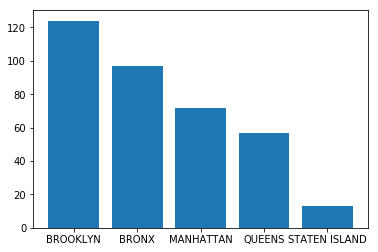

In [29]:
# Histogram
plt.bar("Borough", "Crime_Count", data=crime_boro)

<BarContainer object of 6 artists>

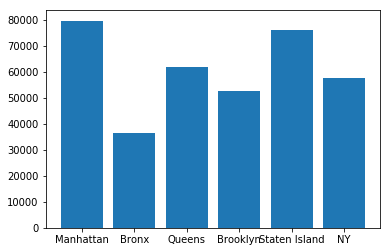

In [30]:
# Median Income Data by Borough
plt.bar("Borough","Median Household Income", data=income_data_convert)

Combined the data of felony crime and median household income, Statan Island is the best choice. 

### Hostest Neighborhoods Selection in Statan Island

In [31]:
island_data = neighborhoods[neighborhoods['Borough'] == 'Staten Island'].reset_index(drop=True)
island_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Staten Island,St. George,40.644982,-74.079353
1,Staten Island,New Brighton,40.640615,-74.087017
2,Staten Island,Stapleton,40.626928,-74.077902
3,Staten Island,Rosebank,40.615305,-74.069805
4,Staten Island,West Brighton,40.631879,-74.107182


In [32]:
print("There are {} neighborhoods totally in Staten Island.".format(len(island_data['Neighborhood'].unique())))

There are 63 neighborhoods totally in Staten Island.


#### Explore the neighborhoods

Define the function to repeat the process to the nearby venues for all the neighborhoods

In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [34]:
LIMIT =100
# Get the venues data
island_venues = getNearbyVenues(names=island_data['Neighborhood'],
                                   latitudes=island_data['Latitude'],
                                   longitudes=island_data['Longitude']
                                  )

St. George
New Brighton
Stapleton
Rosebank
West Brighton
Grymes Hill
Todt Hill
South Beach
Port Richmond
Mariner's Harbor
Port Ivory
Castleton Corners
New Springville
Travis
New Dorp
Oakwood
Great Kills
Eltingville
Annadale
Woodrow
Tottenville
Tompkinsville
Silver Lake
Sunnyside
Park Hill
Westerleigh
Graniteville
Arlington
Arrochar
Grasmere
Old Town
Dongan Hills
Midland Beach
Grant City
New Dorp Beach
Bay Terrace
Huguenot
Pleasant Plains
Butler Manor
Charleston
Rossville
Arden Heights
Greenridge
Heartland Village
Chelsea
Bloomfield
Bulls Head
Richmond Town
Shore Acres
Clifton
Concord
Emerson Hill
Randall Manor
Howland Hook
Elm Park
Manor Heights
Willowbrook
Sandy Ground
Egbertville
Prince's Bay
Lighthouse Hill
Richmond Valley
Fox Hills


In [35]:
print(island_venues.shape)
island_venues.head()

(825, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,St. George,40.644982,-74.079353,Beso,40.643306,-74.076508,Tapas Restaurant
1,St. George,40.644982,-74.079353,Staten Island September 11 Memorial,40.646767,-74.076510,Monument / Landmark
2,St. George,40.644982,-74.079353,Richmond County Bank Ballpark,40.645056,-74.076864,Baseball Stadium
3,St. George,40.644982,-74.079353,A&S Pizzeria,40.643940,-74.077626,Pizza Place
4,St. George,40.644982,-74.079353,St. George Theatre,40.642253,-74.077496,Theater


In [36]:
# The top 10 neighborhoods with most recommended venues
venue_count = island_venues.groupby('Neighborhood')['Venue'].count()
venue_count = pd.DataFrame(venue_count)
venue_count = venue_count.sort_values(by=['Venue'], ascending=False).reset_index()
venue_count.columns = ["Neighborhood","Venue Count"]
venue_count.head(10)

,Neighborhood,Venue Count
0,Bulls Head,42
1,Eltingville,40
2,West Brighton,37
3,Charleston,31
4,St. George,30
5,Stapleton,29
6,New Dorp,27
7,Tompkinsville,27
8,New Springville,27
9,Grant City,26


In [37]:
print('There are {} uniques categories.'.format(len(island_venues['Venue Category'].unique())))

There are 176 uniques categories.


Based on the above list of venues count, Bulls Head is the hostest neighborhood with most recommended vanues. However, we still consider the specific category features for all these neighborhoods further in the next step. Then, we combine all the information to give recommendations.    

### Explore the specfic features of neighborhoods

#### The top 10 most common venues for each neighborhoods

In [38]:
# one hot encoding
island_onehot = pd.get_dummies(island_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
island_onehot['Neighborhood'] = island_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [island_onehot.columns[-1]] + list(island_onehot.columns[:-1])
island_onehot = island_onehot[fixed_columns]

In [39]:
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
island_grouped = island_onehot.groupby('Neighborhood').mean().reset_index()

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [64]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = island_grouped['Neighborhood']

for ind in np.arange(island_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(island_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Annadale,American Restaurant,Restaurant,Sports Bar,Diner,Train Station,Pizza Place,Electronics Store,Food,Flower Shop,Filipino Restaurant
1,Arden Heights,Pharmacy,Smoke Shop,Playground,Coffee Shop,Pizza Place,Food,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
2,Arlington,Intersection,Bus Stop,Boat or Ferry,American Restaurant,Video Store,Eastern European Restaurant,Food & Drink Shop,Food,Flower Shop,Filipino Restaurant
3,Arrochar,Deli / Bodega,Italian Restaurant,Bus Stop,Liquor Store,Hotel,Cosmetics Shop,Pizza Place,Sandwich Place,Outdoors & Recreation,Food Truck
4,Bay Terrace,Italian Restaurant,Supermarket,Shipping Store,Insurance Office,Playground,Salon / Barbershop,Sushi Restaurant,Liquor Store,Donut Shop,Eastern European Restaurant


#### Cluster Neighborhoods based on categories

Run k-means to cluster the neighborhood into 5 clusters.

In [65]:
# set number of clusters
kclusters = 5

island_grouped_clustering = island_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(island_grouped_clustering)

Create a new dataframe that includes the cluster and venues count as well as the top 10 venues for each neighborhood.

In [66]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

island_merged = island_data

# merge island_grouped with island_data to add latitude/longitude venue_count to add the venues count for each neighborhood
island_merged = island_merged.join(venue_count.set_index('Neighborhood'), on='Neighborhood')
island_merged = island_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


In [67]:
# Check whether there are unmatched neighborhoods with NA value
island_merged.loc[island_merged['Cluster Labels'].isna(),]

,Borough,Neighborhood,Latitude,Longitude,Venue Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Staten Island,Port Ivory,40.639683,-74.174645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,Staten Island,Howland Hook,40.638433,-74.186223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# Remove the 2 neighborhoods without any recommeded venues
island_merged = island_merged.drop([10,53]).reset_index()
island_merged = island_merged.drop(["index"],axis=1)

In [71]:
island_merged["Cluster Labels"] = island_merged["Cluster Labels"].astype("int64")
island_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Venue Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Staten Island,St. George,40.644982,-74.079353,30.0,0,Clothing Store,Italian Restaurant,Bar,American Restaurant,Steakhouse,Sporting Goods Shop,Snack Place,Bus Stop,Scenic Lookout,Pizza Place
1,Staten Island,New Brighton,40.640615,-74.087017,13.0,2,Bus Stop,Deli / Bodega,Park,Discount Store,Convenience Store,Playground,Bowling Alley,Home Service,Eastern European Restaurant,Flower Shop
2,Staten Island,Stapleton,40.626928,-74.077902,29.0,0,Pizza Place,Discount Store,Mexican Restaurant,Sandwich Place,Bank,Fast Food Restaurant,Spanish Restaurant,Skate Park,Sri Lankan Restaurant,Chinese Restaurant
3,Staten Island,Rosebank,40.615305,-74.069805,25.0,0,Pizza Place,Italian Restaurant,Mexican Restaurant,Grocery Store,Intersection,Beach,Cosmetics Shop,Pharmacy,Restaurant,Donut Shop
4,Staten Island,West Brighton,40.631879,-74.107182,37.0,0,Bank,Coffee Shop,Italian Restaurant,Music Store,Bar,Pharmacy,American Restaurant,Café,Chinese Restaurant,Sandwich Place


# Results

In the part of results, the ordered list of neighborhoods with venues count is given to display which neighborhoods are more popular. Also, the clusters of neirborhoods are shown the a map. Besides, the details of clusters are given to obser the characteristics of neighborhoods.   

### Ordered Neighborhoods by Popularity

In [91]:
venue_count

,Neighborhood,Venue Count
0,Bulls Head,42
1,Eltingville,40
2,West Brighton,37
3,Charleston,31
4,St. George,30
5,Stapleton,29
6,New Dorp,27
7,Tompkinsville,27
8,New Springville,27
9,Grant City,26


### Clusters on Map

In [72]:
# create map
map_clusters = folium.Map(location=[40.5795, -74.1502], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(island_merged['Latitude'], island_merged['Longitude'], island_merged['Neighborhood'], island_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Observe the characteristics for each cluster

***Cluster 1***

In [114]:
cluster1 = island_merged.loc[island_merged['Cluster Labels'] == 0, island_merged.columns[[0] +[1]+ list(range(4, island_merged.shape[1]))]].sort_values(by=["Venue Count"],ascending=False).reset_index()
del(cluster1['index'])
cluster1.head()

,Borough,Neighborhood,Venue Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Staten Island,Bulls Head,42.0,0,Pizza Place,Bus Stop,Café,Pharmacy,Deli / Bodega,Chinese Restaurant,American Restaurant,Supermarket,Liquor Store,Diner
1,Staten Island,Eltingville,40.0,0,Pizza Place,Sushi Restaurant,Italian Restaurant,Diner,Gourmet Shop,Bank,Fast Food Restaurant,Pharmacy,Train Station,Chinese Restaurant
2,Staten Island,West Brighton,37.0,0,Bank,Coffee Shop,Italian Restaurant,Music Store,Bar,Pharmacy,American Restaurant,Café,Chinese Restaurant,Sandwich Place
3,Staten Island,Charleston,31.0,0,Cosmetics Shop,Big Box Store,American Restaurant,Mobile Phone Shop,Supermarket,Boutique,Furniture / Home Store,Diner,Sporting Goods Shop,Burger Joint
4,Staten Island,St. George,30.0,0,Clothing Store,Italian Restaurant,Bar,American Restaurant,Steakhouse,Sporting Goods Shop,Snack Place,Bus Stop,Scenic Lookout,Pizza Place


***Cluster 2***

In [79]:
cluster2 = island_merged.loc[island_merged['Cluster Labels'] == 1, island_merged.columns[[0] +[1]+ list(range(4, island_merged.shape[1]))]].sort_values(by=["Venue Count"],ascending=False)
cluster2

,Borough,Neighborhood,Venue Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Staten Island,Todt Hill,1.0,1,Park,Yoga Studio,Insurance Office,Food Truck,Food & Drink Shop,Food,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant


***Cluster 3***

In [143]:
cluster3 = island_merged.loc[island_merged['Cluster Labels'] == 2, island_merged.columns[[0] +[1]+ list(range(4, island_merged.shape[1]))]].sort_values(by=["Venue Count"],ascending=False).reset_index()
del(cluster3["index"])
cluster3

,Borough,Neighborhood,Venue Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Staten Island,New Brighton,13.0,2,Bus Stop,Deli / Bodega,Park,Discount Store,Convenience Store,Playground,Bowling Alley,Home Service,Eastern European Restaurant,Flower Shop
1,Staten Island,Sandy Ground,8.0,2,Bus Stop,Intersection,Art Gallery,Home Service,Liquor Store,Market,Fast Food Restaurant,Event Space,Food Truck,Food & Drink Shop
2,Staten Island,Park Hill,6.0,2,Bus Stop,Hotel,Athletics & Sports,Coffee Shop,Gym / Fitness Center,Yoga Studio,Falafel Restaurant,Food Truck,Food & Drink Shop,Food
3,Staten Island,Randall Manor,6.0,2,Bus Stop,Park,Playground,Bagel Shop,Yoga Studio,Falafel Restaurant,Food Truck,Food & Drink Shop,Food,Flower Shop
4,Staten Island,Willowbrook,6.0,2,Bus Stop,Chinese Restaurant,Jewish Restaurant,Pizza Place,Event Space,Food Truck,Food & Drink Shop,Food,Flower Shop,Filipino Restaurant
5,Staten Island,Bloomfield,5.0,2,Recreation Center,Theme Park,Discount Store,Bus Stop,Park,Food & Drink Shop,Food,Flower Shop,Filipino Restaurant,Fast Food Restaurant
6,Staten Island,Chelsea,4.0,2,Steakhouse,Bus Stop,Sandwich Place,Park,Electronics Store,Food & Drink Shop,Food,Flower Shop,Filipino Restaurant,Fast Food Restaurant
7,Staten Island,Fox Hills,4.0,2,Bus Stop,Sandwich Place,Grocery Store,Yoga Studio,Electronics Store,Food & Drink Shop,Food,Flower Shop,Filipino Restaurant,Fast Food Restaurant
8,Staten Island,Grymes Hill,3.0,2,Bus Stop,Dog Run,Men's Store,Yoga Studio,Falafel Restaurant,Food Truck,Food & Drink Shop,Food,Flower Shop,Filipino Restaurant
9,Staten Island,Oakwood,3.0,2,Bus Stop,Playground,Bar,Yoga Studio,Event Space,Food Truck,Food & Drink Shop,Food,Flower Shop,Filipino Restaurant


***Cluster 4***

In [81]:
cluster4 = island_merged.loc[island_merged['Cluster Labels'] == 3, island_merged.columns[[0] +[1]+ list(range(4, island_merged.shape[1]))]].sort_values(by=["Venue Count"],ascending=False)
cluster4

,Borough,Neighborhood,Venue Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Staten Island,Emerson Hill,3.0,3,Moving Target,Food,Gym,Yoga Studio,Event Space,Food Truck,Food & Drink Shop,Flower Shop,Filipino Restaurant,Fast Food Restaurant


***Cluster 5***

In [82]:
cluster5 = island_merged.loc[island_merged['Cluster Labels'] == 4, island_merged.columns[[0] +[1]+ list(range(4, island_merged.shape[1]))]].sort_values(by=["Venue Count"],ascending=False)
cluster5

,Borough,Neighborhood,Venue Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Staten Island,Silver Lake,4.0,4,American Restaurant,Burger Joint,Bus Stop,Golf Course,Falafel Restaurant,Food Truck,Food & Drink Shop,Food,Flower Shop,Filipino Restaurant
26,Staten Island,Arlington,4.0,4,Intersection,Bus Stop,Boat or Ferry,American Restaurant,Video Store,Eastern European Restaurant,Food & Drink Shop,Food,Flower Shop,Filipino Restaurant


# Discussion

In this part, each cluster is discussed to give out the recommendations.

***Cluster 1***

In [146]:
for i in range(0, cluster1.shape[0]):
    if cluster1.loc[i,"Venue Count"]<10:
        cluster1_fix = cluster1
        cluster1_fix.iloc[i,-(10-int(cluster1_fix.loc[i,"Venue Count"])):]="NaN"

In [147]:
cluster1_fix

,Borough,Neighborhood,Venue Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Staten Island,Bulls Head,42.0,0,Pizza Place,Bus Stop,Café,Pharmacy,Deli / Bodega,Chinese Restaurant,American Restaurant,Supermarket,Liquor Store,Diner
1,Staten Island,Eltingville,40.0,0,Pizza Place,Sushi Restaurant,Italian Restaurant,Diner,Gourmet Shop,Bank,Fast Food Restaurant,Pharmacy,Train Station,Chinese Restaurant
2,Staten Island,West Brighton,37.0,0,Bank,Coffee Shop,Italian Restaurant,Music Store,Bar,Pharmacy,American Restaurant,Café,Chinese Restaurant,Sandwich Place
3,Staten Island,Charleston,31.0,0,Cosmetics Shop,Big Box Store,American Restaurant,Mobile Phone Shop,Supermarket,Boutique,Furniture / Home Store,Diner,Sporting Goods Shop,Burger Joint
4,Staten Island,St. George,30.0,0,Clothing Store,Italian Restaurant,Bar,American Restaurant,Steakhouse,Sporting Goods Shop,Snack Place,Bus Stop,Scenic Lookout,Pizza Place
5,Staten Island,Stapleton,29.0,0,Pizza Place,Discount Store,Mexican Restaurant,Sandwich Place,Bank,Fast Food Restaurant,Spanish Restaurant,Skate Park,Sri Lankan Restaurant,Chinese Restaurant
6,Staten Island,New Springville,27.0,0,Deli / Bodega,Mobile Phone Shop,Chinese Restaurant,Pizza Place,Bagel Shop,Liquor Store,Martial Arts Dojo,Men's Store,Mexican Restaurant,Grocery Store
7,Staten Island,New Dorp,27.0,0,Italian Restaurant,Pizza Place,Bank,Deli / Bodega,Dim Sum Restaurant,Coffee Shop,Chinese Restaurant,Salon / Barbershop,Sandwich Place,Spa
8,Staten Island,Tompkinsville,27.0,0,Brewery,Bus Stop,Deli / Bodega,Intersection,Pub,Café,Caribbean Restaurant,Chinese Restaurant,Sandwich Place,Rock Club
9,Staten Island,Grant City,26.0,0,Pizza Place,Convenience Store,Fast Food Restaurant,American Restaurant,Grocery Store,Dessert Shop,Cosmetics Shop,Pharmacy,Eastern European Restaurant,Chinese Restaurant


In [152]:
cluster1_fix.shape

(47, 14)

For cluster 1, there are 47 neighborhoods and most are very popular with many recommended venues. The good thing is there are a big group of potential clients for restaurants. However, there are diversified restaurants in these locations already, which contributes to the fierce competition from the imcumbents. Therefore, it's recommended to open one resuarant with more special characteristics to differentiate from imcumbents. More deeper market research should be deployed.

***Cluster 2***

Based on the venue count, 1, the only venue of this neighborhood is a park actually. A big restaurant is not a good choice to open here but a small food or drink shop could be a better choice.

In [101]:
cluster2.iloc[:,0:5]

,Borough,Neighborhood,Venue Count,Cluster Labels,1st Most Common Venue
6,Staten Island,Todt Hill,1.0,1,Park


***Cluster 3***

In [144]:
for i in range(0, cluster3.shape[0]):
    if cluster3.loc[i,"Venue Count"]<10:
        cluster3_fix = cluster3
        cluster3_fix.iloc[i,-(10-int(cluster3_fix.loc[i,"Venue Count"])):]="NaN"

In [145]:
cluster3_fix

,Borough,Neighborhood,Venue Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Staten Island,New Brighton,13.0,2,Bus Stop,Deli / Bodega,Park,Discount Store,Convenience Store,Playground,Bowling Alley,Home Service,Eastern European Restaurant,Flower Shop
1,Staten Island,Sandy Ground,8.0,2,Bus Stop,Intersection,Art Gallery,Home Service,Liquor Store,Market,Fast Food Restaurant,Event Space,NaN,NaN
2,Staten Island,Park Hill,6.0,2,Bus Stop,Hotel,Athletics & Sports,Coffee Shop,Gym / Fitness Center,Yoga Studio,NaN,NaN,NaN,NaN
3,Staten Island,Randall Manor,6.0,2,Bus Stop,Park,Playground,Bagel Shop,Yoga Studio,Falafel Restaurant,NaN,NaN,NaN,NaN
4,Staten Island,Willowbrook,6.0,2,Bus Stop,Chinese Restaurant,Jewish Restaurant,Pizza Place,Event Space,Food Truck,NaN,NaN,NaN,NaN
5,Staten Island,Bloomfield,5.0,2,Recreation Center,Theme Park,Discount Store,Bus Stop,Park,NaN,NaN,NaN,NaN,NaN
6,Staten Island,Chelsea,4.0,2,Steakhouse,Bus Stop,Sandwich Place,Park,NaN,NaN,NaN,NaN,NaN,NaN
7,Staten Island,Fox Hills,4.0,2,Bus Stop,Sandwich Place,Grocery Store,Yoga Studio,NaN,NaN,NaN,NaN,NaN,NaN
8,Staten Island,Grymes Hill,3.0,2,Bus Stop,Dog Run,Men's Store,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Staten Island,Oakwood,3.0,2,Bus Stop,Playground,Bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For this cluster, Bus stop and park are the main venues. Most restaurants are fast food so fast food restaurant or food truck which can let the clients pick up foods quickly and easierly could be good choices. Among this cluster, New Brighton is the most popular meighborhood with 13 recommended venues. 

***Cluster 4***

In [149]:
cluster4.iloc[:,0:7]

,Borough,Neighborhood,Venue Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
50,Staten Island,Emerson Hill,3.0,3,Moving Target,Food,Gym


For cluster 4, only one neighborhood with only 3 vennues without significant characteristics. It's worth to do some field research to judge whether it's suitable to open restaurants.  

***Cluster 5***

In [151]:
cluster5.iloc[:,0:8]

,Borough,Neighborhood,Venue Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
21,Staten Island,Silver Lake,4.0,4,American Restaurant,Burger Joint,Bus Stop,Golf Course
26,Staten Island,Arlington,4.0,4,Intersection,Bus Stop,Boat or Ferry,American Restaurant


For cluster 5, the both neighborhoods are same popular although Silver Lake has owned popular restaurant. Relatively speaking, Arlington is a better choice to open a restaurant to provide fast food to avoice the competition from imcumbents because it seems a popular transpotation place. 

# Conclusion

All in all, different recommendations to open restaurants are given for different clusters. Combining the analysis, the recommendations are given:
- Staten Island is the best choice of borugh in New York City to open small-sized restaurants because of the lower felony crime rate and higher median household income.
- Todt Hill is a good neighborhood to provide fast food, health food or drinks to people who love park or outdoor activitiess.
- Cluster 4 & 5 are less recommended locations to open restaurants due to the lower popularity.
- Cluster 3 is a group of neighborhoods to open fast food restaurants or food trucks to provide people who are waiting buses. Considering popularity, New Brighton is the best choice.
- The neightborhoods in Cluster 1 have lots of potential clients for restaurants but face the highly competition. Therefore, a medium- or big-sized restaurants with differential features could be good choice for these locations. Considering the popularity, Bulls Head, Eltingville and West Brighton are best chocies of neighborhoods.